## 📚 Table of Contents

1. [Introduction](#introduction)
2. [Data Exploration](#data-exploration)
3. [Data Cleaning & Manipulation](#data-cleaning--manipulation)
4. [Exploratory Data Analysis](#exploratory-data-analysis)

# Introduction

Breast cancer is the most frequent cancer in women and also the most common overall. Lunasin extract (LE) is a protein known to inhibit cancer progression via various pathways. This dataset explores the effect of LE on two common phenotypic markers in breast cancer, epithelial cadherins (E-Cadherin) and Intercellular Adhesion Molecule 1 (ICAM-1). The expression of E-Cadherin and ICAM-1 was quantified using H-Score, with the following formula:

(% low positive × 1) + (% positive × 2) + (% high positive × 3)

#### Statistical Analysis

I replicated the analysis done in the paper ["The potential of lunasin extract for the prevention of breast cancer progression by upregulating E-Cadherin and inhibiting ICAM-1"](https://doi.org/10.12688/f1000research.55385.1) by Kusmardi et.al.,

Data analysis was done with the use of One-Way Analysis of Variance (ANOVA), followed by a Tukey Honest Significant Difference (HSD) to compare the differences between groups. Differences of p < 0.05 are considered statistically significant. 

A correlation analysis was then performed between E-Cadherin and ICAM-1 expression using Pearson Correlation, where the correlation coefficient value (r) can take on values between 1 and -1. 1 shows a strong positive relationship, -1 shows a strong negative relationship and 0 shows no relationship. This was then visualised using simple linear regression.

#### Data Source

The dataset is available [here](https://doi.org/10.7910/DVN/EXUSQ2). The Licence/Data use agreement falls under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/)

#### Setting up the environment

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [137]:
# The original dataset was converted to a csv to prevent encoding issues and ffill was used as the original dataset had merged cells.
e_cad = pd.read_csv("E-Cadherin Raw Data.csv").ffill()
icam1 = pd.read_csv("ICAM-1 Raw Data.csv").ffill()

## Data Exploration

In [138]:
# Exploring the datasets
print(e_cad.info())
print(e_cad.describe())
print(icam1.info())
print(icam1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Slide                240 non-null    object 
 1   Visual Field         240 non-null    int64  
 2   Negative (-)         240 non-null    float64
 3   Low Positive (+)     240 non-null    float64
 4   Postive (++)         240 non-null    float64
 5   High Positive (+++)  240 non-null    float64
 6   H Score              240 non-null    float64
 7   Average              240 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 15.1+ KB
None
       Visual Field  Negative (-)  Low Positive (+)  Postive (++)  \
count    240.000000    240.000000        240.000000    240.000000   
mean       5.500000     52.609766         33.502511     11.630305   
std        2.878284     12.567177          7.349364      7.365352   
min        1.000000     23.628000          5.906400 

In [139]:
# Checking class distribution
print(e_cad["Slide"].value_counts())
print(icam1["Slide"].value_counts())

Slide
A1C5    10
A2C2    10
G9C2    10
G9C1    10
G8C7    10
F4KM    10
F3KM    10
F2KM    10
F1KM    10
E5C1    10
E4C7    10
E4C2    10
E1C3    10
C6C4    10
C3C3    10
C2C5    10
C1C1    10
D5C2    10
D4C7    10
D3C2    10
D1C3    10
A5C4    10
A3C4    10
G9C7    10
Name: count, dtype: int64
Slide
A1C5    10
A2C2    10
G9C2    10
G9C1    10
G8C7    10
F4KM    10
F3KM    10
F2KM    10
F1KM    10
E5C1    10
E4C7    10
E4C2    10
E1C3    10
C6C4    10
C3C3    10
C2C5    10
C1C1    10
D5C2    10
D4C7    10
D3C2    10
D1C3    10
A5C4    10
A3C4    10
G9C7    10
Name: count, dtype: int64


In [140]:
# Checking no. of duplicate rows
print(e_cad.duplicated().sum())
print(icam1.duplicated().sum())

0
0


## Data Cleaning & Manipulation

Before analysis I need to:
1. Remove the average column (was a merged cell in original dataset)
2. Add a column describing the "research group" based on the slide number
3. Calculate the H Score to more decimal places

In [141]:
# Remove average column
e_cad.drop(["Average"], axis=1, inplace=True)
icam1.drop(["Average"], axis=1, inplace=True)

In [142]:
# Function to add research group column
def get_research_group(i):
    if i == "A":
        return "Curative"
    elif i == "F":
        return "Normal Control"
    elif i == "E":
        return "Negative Control"
    elif i == "D":
        return "Positive Control"
    elif i == "C":
        return "Adjuvant"
    else:

        return "Preventive"

# Adding research group column to dataset
e_cad["Research Group"] = [get_research_group(x[:1]) for x in e_cad["Slide"]]
icam1["Research Group"] = [get_research_group(x[:1]) for x in icam1["Slide"]]

In [143]:
# Calculating H-Score
e_cad["H Score"] = (
    (e_cad["Low Positive (+)"])
    + (e_cad["Postive (++)"] * 2)
    + (e_cad["High Positive (+++)"] * 3)
)

icam1["H Score"] = (
    (icam1["Low Positive (+)"])
    + (icam1["Postive (++)"] * 2)
    + (icam1["High Positive (+++)"] * 3)
)

## Exploratory Data Analysis

#### What is the expression of E-Cadherin in all groups?

In [144]:
# Calculating the average H-Score between each Slide and Research Group
average_e_cad = (
    e_cad.groupby(["Slide", "Research Group"])["H Score"].mean().reset_index()
)

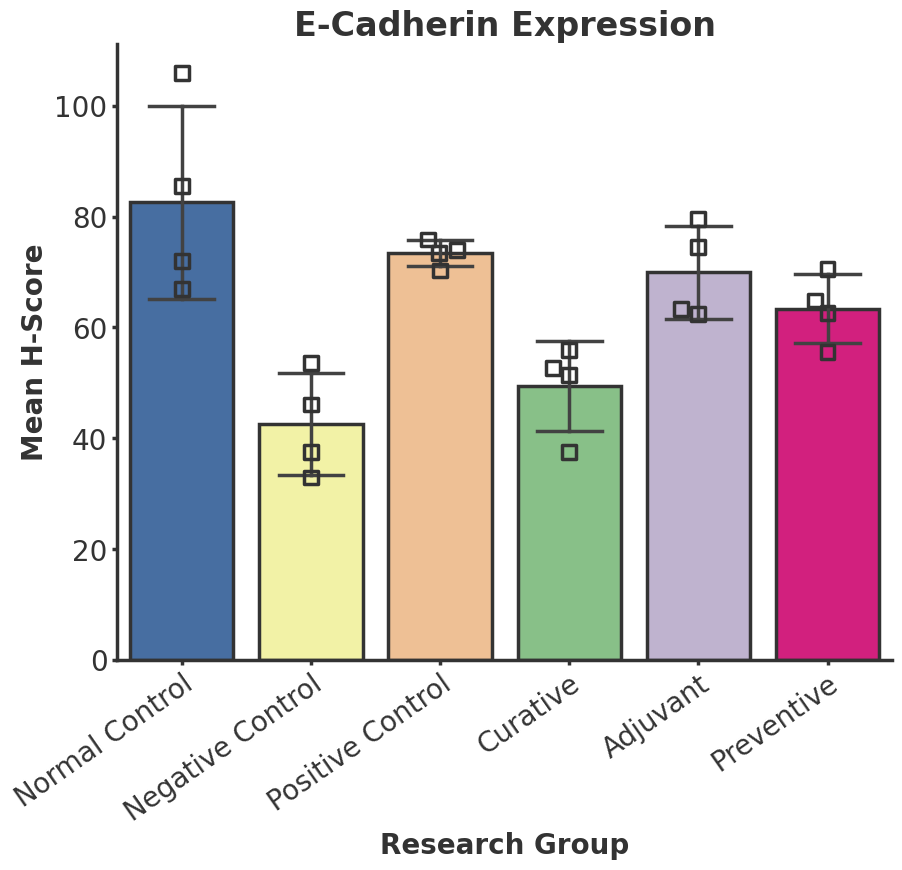

In [145]:
# Setting the size of plot
plt.figure(figsize=(10, 8))

# Creating a custom order
custom_order = [
    "Normal Control",
    "Negative Control",
    "Positive Control",
    "Curative",
    "Adjuvant",
    "Preventive",
]

# Creating a bar plot
ax = sns.barplot(
    x="Research Group",
    y="H Score",
    order=custom_order,
    errorbar="sd",
    data=average_e_cad,
    hue="Research Group",
    palette="Accent",
    capsize=0.5,
    lw=2.5,
    edgecolor="0.2",

    err_kws={"linewidth": 2.5},
)

# Creating a swarm plot
kwargs = {"edgecolor": "0.2", "linewidth": 2.5, "fc": "none"}
ax = sns.swarmplot(
    x="Research Group", y="H Score", data=average_e_cad, marker="s", s=10, **kwargs
)

# Editing the spines of the plot
for axis in ["bottom", "left"]:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color("0.2")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Editing the ticks and labels of the plot
plt.xticks(size=20, rotation=35, rotation_mode="anchor", ha="right", color="0.2")
plt.yticks(size=20, color="0.2")
ax.tick_params(width=2.5, color="0.2")
ax.set_title("E-Cadherin Expression", size=24, weight="bold", color="0.2")
ax.set_xlabel("Research Group", weight="bold", size=20, color="0.2")
ax.set_ylabel("Mean H-Score", weight="bold", size=20, color="0.2")

# Show plot
plt.show()

Are the differences between groups significant?

In [146]:
# One-way ANOVA
f_statistic, p_value = f_oneway(
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Adjuvant"],
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Curative"],
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Negative Control"],
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Normal Control"],
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Positive Control"],
    average_e_cad["H Score"][average_e_cad["Research Group"] == "Preventive"],
)
print(f"One-way ANOVA F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

One-way ANOVA F-statistic: 9.641459658251966
P-value: 0.00013145859910820723


- The ad-hoc test suggests that there is a significant difference between the means of atleast two groups.

In [147]:
# Tukey Honest Significant Difference (HSD) test
tukey_e_cad = pairwise_tukeyhsd(
    average_e_cad["H Score"], average_e_cad["Research Group"]
)
print(tukey_e_cad)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
        Adjuvant         Curative -20.5882 0.0722  -42.473  1.2965  False
        Adjuvant Negative Control -27.4401 0.0095 -49.3249 -5.5553   True
        Adjuvant   Normal Control  12.6079 0.4721  -9.2769 34.4927  False
        Adjuvant Positive Control    3.435 0.9956 -18.4498 25.3197  False
        Adjuvant       Preventive  -6.5881 0.9257 -28.4729 15.2967  False
        Curative Negative Control  -6.8519 0.9136 -28.7366 15.0329  False
        Curative   Normal Control  33.1961 0.0016  11.3114 55.0809   True
        Curative Positive Control  24.0232 0.0268   2.1384  45.908   True
        Curative       Preventive  14.0001  0.363  -7.8846 35.8849  False
Negative Control   Normal Control   40.048 0.0002  18.1632 61.9328   True
Negative Control Positive Control  30.

- The post-hoc test suggests that there are significant differences in E-Cadherin expression between:
1. Adjuvant, Negative Control
2. Curative, Normal Control
3. Curative, Positive Control
4. Negative Control, Normal Control
5. Negative Control, Positive Control

#### What is the expression of ICAM-1 in all groups?

In [148]:
# Calculating the average H-Score between each Slide and Research Group
average_icam1 = (
    icam1.groupby(["Slide", "Research Group"])["H Score"].mean().reset_index()
)

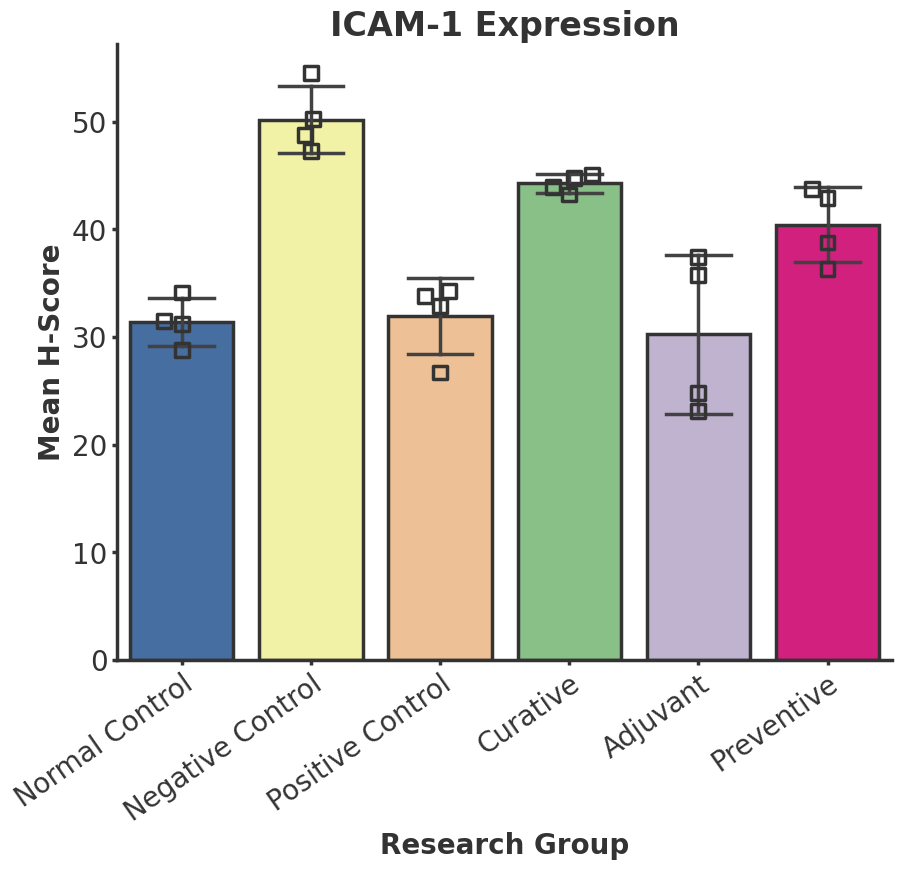

In [149]:
# Setting the size of plot
plt.figure(figsize=(10, 8))

# Creating a bar plot
ax = sns.barplot(
    x="Research Group",
    y="H Score",
    order=custom_order,
    errorbar="sd",
    data=average_icam1,
    hue="Research Group",
    palette="Accent",
    capsize=0.5,
    lw=2.5,
    edgecolor="0.2",
    err_kws={"linewidth": 2.5},
)

# Adding a swarm plot
kwargs = {"edgecolor": "0.2", "linewidth": 2.5, "fc": "none"}
ax = sns.swarmplot(
    x="Research Group", y="H Score", data=average_icam1, marker="s", s=10, **kwargs
)

# Editing the spines of the plot
for axis in ["bottom", "left"]:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color("0.2")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Editing the ticks and labels of the plot
plt.xticks(size=20, rotation=35, rotation_mode="anchor", ha="right", color="0.2")
plt.yticks(size=20, color="0.2")
ax.tick_params(width=2.5, color="0.2")
ax.set_title("ICAM-1 Expression", size=24, weight="bold", color="0.2")
ax.set_xlabel("Research Group", weight="bold", size=20, color="0.2")
ax.set_ylabel("Mean H-Score", weight="bold", size=20, color="0.2")

# Show plot
plt.show()

In [150]:
# One-way ANOVA
f_statistic, p_value = f_oneway(
    average_icam1["H Score"][average_icam1["Research Group"] == "Adjuvant"],
    average_icam1["H Score"][average_icam1["Research Group"] == "Curative"],
    average_icam1["H Score"][average_icam1["Research Group"] == "Negative Control"],
    average_icam1["H Score"][average_icam1["Research Group"] == "Normal Control"],
    average_icam1["H Score"][average_icam1["Research Group"] == "Positive Control"],
    average_icam1["H Score"][average_icam1["Research Group"] == "Preventive"],
)
print(f"One-way ANOVA F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

One-way ANOVA F-statistic: 16.9762643264765
P-value: 2.9308331113088938e-06


- The ad-hoc test suggests that there is a significant difference between the means of atleast two groups.

In [151]:
# Tukey Honest Significant Difference (HSD) test
tukey_icam1 = pairwise_tukeyhsd(
    average_icam1["H Score"], average_icam1["Research Group"]
)
print(tukey_icam1)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
        Adjuvant         Curative  13.9936 0.0011   5.0826 22.9046   True
        Adjuvant Negative Control  19.9153    0.0  11.0043 28.8263   True
        Adjuvant   Normal Control    1.133 0.9984  -7.7781  10.044  False
        Adjuvant Positive Control    1.662 0.9902   -7.249 10.5731  False
        Adjuvant       Preventive  10.1596 0.0203   1.2486 19.0706   True
        Curative Negative Control   5.9217 0.3246  -2.9893 14.8328  False
        Curative   Normal Control -12.8606 0.0027 -21.7717 -3.9496   True
        Curative Positive Control -12.3315  0.004 -21.2426 -3.4205   True
        Curative       Preventive   -3.834 0.7449  -12.745   5.077  False
Negative Control   Normal Control -18.7824    0.0 -27.6934 -9.8713   True
Negative Control Positive Control -18.

- The post-hoc test suggests that there are significant differences in ICAM-1 expression between:
1. Adjuvant, Curative
2. Adjuvant, Negative Control
3. Adjuvant, Preventive
4. Curative, Normal Control
5. Curative, Positive Control
6. Negative Control, Normal Control
7. Negative Control, Positive Control
8. Negative Control, Preventive
9. Normal Control, Preventive

#### Is there a correlation between E-Cadherin and ICAM-1 expression?

In [152]:
stats.pearsonr(average_e_cad["H Score"], average_icam1["H Score"])

PearsonRResult(statistic=-0.6160410585512165, pvalue=0.0013499928500025904)

- The Pearson correlation analysis shows that there is a negative correlation between E-Cadherin and ICAM-1 expression with moderate strength. 

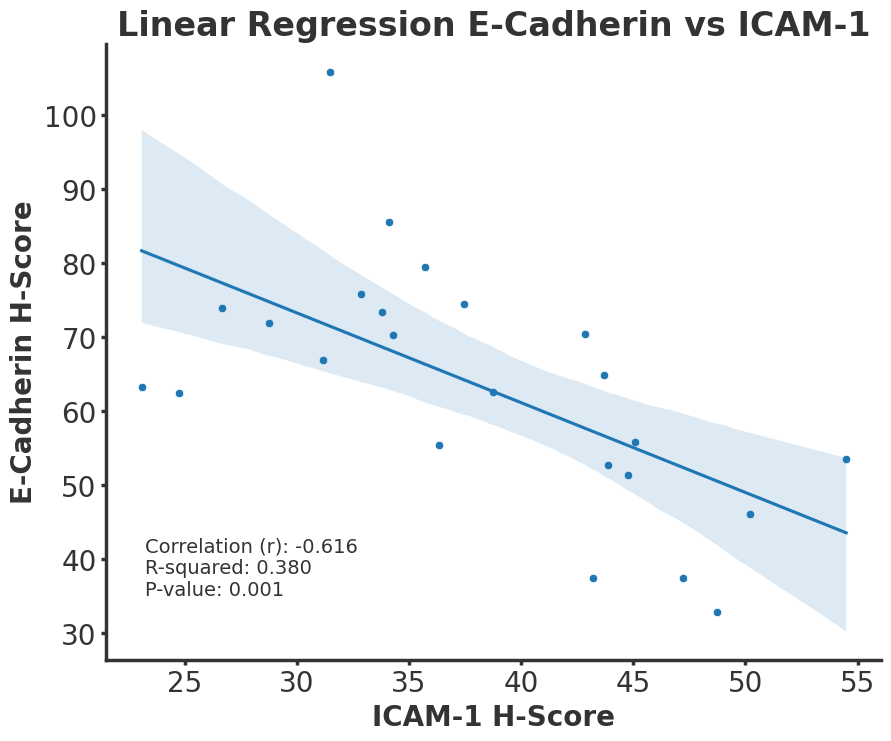

In [153]:
# Setting the size of plot
plt.figure(figsize=(10, 8))

# Creating a bar plot
ax = sns.scatterplot(x=average_icam1["H Score"], y=average_e_cad["H Score"])

# Editing the spines of the plot
for axis in ["bottom", "left"]:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color("0.2")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adding linear regression line
sns.regplot(
    x=average_icam1["H Score"], y=average_e_cad["H Score"], scatter=False, ax=ax
)

# Editing the ticks and labels of the plot
plt.xticks(size=20, color="0.2")
plt.yticks(size=20, color="0.2")
ax.tick_params(width=2.5, color="0.2")
ax.set_title(
    "Linear Regression E-Cadherin vs ICAM-1", size=24, weight="bold", color="0.2"
)
ax.set_xlabel("ICAM-1 H-Score", size=20, weight="bold", color="0.2")
ax.set_ylabel("E-Cadherin H-Score", size=20, weight="bold", color="0.2")

# Calculate correlation coefficient (r) and p-value
corr_coeff, p_value = stats.pearsonr(average_icam1["H Score"], average_e_cad["H Score"])

# Add text to display correlation coefficient (r), R-squared and p-value
textstr = f"Correlation (r): {corr_coeff:.3f}\nR-squared: {(corr_coeff**2):.3f}\nP-value: {p_value:.3f}"
ax.text(
    0.05,
    0.2,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    color="0.2",
)

# Show plot
plt.show()